<a href="https://colab.research.google.com/github/AnovaYoung/Computer-Vision/blob/main/GAN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1- Digit generator**

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
#a- Reading data
import tensorflow as tf

# Load the mnist dataset from tf.keras
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape and normalize the images
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Constants
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Layers of the model
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    # Return the constructed model
    return model


In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

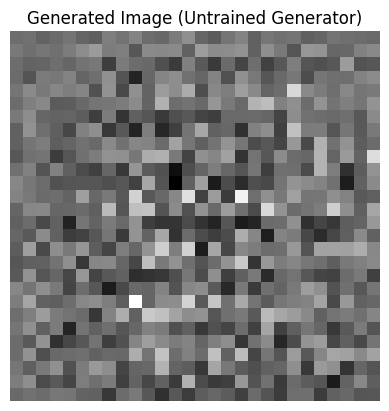

In [ ]:
import matplotlib.pyplot as plt

# Use the generator model which is not trained yet to create an image
generator = make_generator_model()  # Call the function to create the generator

# Generate noise
noise = tf.random.normal([1, 100])  # This creates the noise

# Generate an image using the noise
generated_image = generator(noise, training=False)

# Visualize the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title("Generated Image (Untrained Generator)")
plt.axis('off')
plt.show()


In [ ]:
# what is this image?

The image isn an unstructured pattern generated by the *untrained* generator model. At this stage, the generator has not yet learned how to create a meaningful image, such as digits or anything recognizable. Instead, it produces output based solely on random noise passed through its layers.

In [ ]:
def make_discriminator_model():
    """
    Creates the discriminator model.

    Returns:
        model (tf.keras.Sequential): The discriminator model.
    """
    model = tf.keras.Sequential()
    # First Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and Dense output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


# Initialize the discriminator model and confirm it works
discriminator = make_discriminator_model()
discriminator.summary()  # Print the model architecture

# Test the discriminator with a dummy input
sample_input = tf.random.normal([1, 28, 28, 1])  # Single "image"
output = discriminator(sample_input)
print(f"Discriminator test output: {output.numpy()}")




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator test output: [[0.09150113]]


In [ ]:
# Applying discriminator model to an untrained generator output

# Generate a single image using the untrained generator
noise = tf.random.normal([1, noise_dim])  # Generate random noise
generated_image = generator(noise, training=False)  # Use the generator to produce an image

# Use the discriminator to classify the generated image
decision = discriminator(generated_image)

print("Generated image shape:", generated_image.shape)
print("Discriminator decision on untrained generator output:", decision.numpy())


Generated image shape: (1, 28, 28, 1)
Discriminator decision on untrained generator output: [[-0.00215003]]


In [ ]:
# Initialize a helper function for cross-entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Print confirmation
print("Cross-entropy loss function initialized successfully:", cross_entropy)


Cross-entropy loss function initialized successfully: <keras.src.losses.losses.BinaryCrossentropy object at 0x7add409630d0>


In [ ]:
# Discriminator loss function
def discriminator_loss(real_output, fake_output):
    """
    Calculates the discriminator loss for distinguishing real and fake images.

    Args:
        real_output (Tensor): Discriminator output for real images.
        fake_output (Tensor): Discriminator output for generated (fake) images.

    Returns:
        Tensor: Total loss for the discriminator.
    """
    # Loss for real images (discriminator should classify these as 1)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Loss for fake images (discriminator should classify these as 0)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # Total discriminator loss
    total_loss = real_loss + fake_loss
    return total_loss


# Test the discriminator loss function
real_output_test = tf.random.normal([16, 1])  # Example real logits
fake_output_test = tf.random.normal([16, 1])  # Example fake logits

# Calculate loss
disc_loss_test = discriminator_loss(real_output_test, fake_output_test)

# Print results
print("Discriminator loss function initialized successfully.")
print(f"Real Output Sample: {real_output_test.numpy()[:5]}")  # Print first 5 real outputs
print(f"Fake Output Sample: {fake_output_test.numpy()[:5]}")  # Print first 5 fake outputs
print(f"Discriminator Loss: {disc_loss_test.numpy()}")


Discriminator loss function initialized successfully.
Real Output Sample: [[-0.21845944]
 [ 0.13440321]
 [-0.76789314]
 [-0.41444868]
 [-1.133255  ]]
Fake Output Sample: [[-0.28281137]
 [-2.7104194 ]
 [ 0.72941244]
 [ 0.28220809]
 [ 1.1323752 ]]
Discriminator Loss: 1.6390520334243774


In [ ]:
# Generator loss function
def generator_loss(fake_output):
    """
    Calculates the generator loss based on how well it fools the discriminator.

    Args:
        fake_output (Tensor): Discriminator predictions for generated (fake) images.

    Returns:
        Tensor: Loss for the generator.
    """
    # Generator wants discriminator to classify fake images as real (1)
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


# Test the generator loss function
fake_output_test = tf.random.normal([16, 1])  # Example fake logits

# Calculate loss
gen_loss_test = generator_loss(fake_output_test)

# Print results
print("Generator loss function initialized successfully.")
print(f"Fake Output Sample: {fake_output_test.numpy()[:5]}")  # Print first 5 fake outputs
print(f"Generator Loss: {gen_loss_test.numpy()}")


Generator loss function initialized successfully.
Fake Output Sample: [[-0.7709284 ]
 [ 0.38160768]
 [ 0.13251859]
 [ 0.10223176]
 [-0.50589556]]
Generator Loss: 0.6841980218887329


In [ ]:
# Initialize optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Print confirmation
print("Generator and discriminator optimizers initialized successfully.")
print(f"Generator Optimizer: {generator_optimizer}")
print(f"Discriminator Optimizer: {discriminator_optimizer}")


Generator and discriminator optimizers initialized successfully.
Generator Optimizer: <keras.src.optimizers.adam.Adam object at 0x7add40961c60>
Discriminator Optimizer: <keras.src.optimizers.adam.Adam object at 0x7add40962f50>


In [ ]:
# e- Model design
# Let's save the model for future references
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Import TensorFlow and check for GPU availability
import tensorflow as tf
import time

# Model parameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed for generating consistent images to visualize progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Debug checks to confirm parameters are correctly set
print(f"EPOCHS: {EPOCHS}")
print(f"Noise dimension: {noise_dim}")
print(f"Number of examples to generate: {num_examples_to_generate}")
print(f"Shape of seed: {seed.shape}")
print(f"Sample seed values:\n{seed.numpy()}")


EPOCHS: 50
Noise dimension: 100
Number of examples to generate: 16
Shape of seed: (16, 100)
Sample seed values:
[[-2.230908    0.26776442  0.14378461 ...  0.20036702 -0.2826844
  -1.6348922 ]
 [-0.07060958 -0.61992586 -0.09422883 ... -0.7814417   0.53568447
  -0.82291657]
 [-0.34527418 -0.5419441   0.50006413 ... -1.8385206  -2.0197923
   0.3297386 ]
 ...
 [ 0.80053866  1.077233    0.8483964  ...  1.1909261  -0.548022
  -1.776169  ]
 [-0.12570618 -0.1836713  -1.0959481  ...  0.4217336   0.42389727
  -1.1876436 ]
 [ 0.1574923  -1.3449655  -0.6679684  ... -0.25118896 -0.5131222
   1.3227456 ]]


In [ ]:
@tf.function  # Compiles the function for faster execution
def train_step(images):
    """
    Executes one training step for both the generator and discriminator.

    Args:
        images (Tensor): A batch of real images from the training dataset.
    """
    # Generate random noise for the generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Open gradient tapes for both generator and discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images using the generator
        generated_images = generator(noise, training=True)

        # Get discriminator predictions for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output)  # Generator tries to "trick" the discriminator
        disc_loss = discriminator_loss(real_output, fake_output)  # Discriminator distinguishes real from fake

    # Calculate gradients for both generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to update model weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Print losses for debugging purposes
    tf.print("Train step completed.")
    tf.print("Generator Loss:", gen_loss)
    tf.print("Discriminator Loss:", disc_loss)


In [ ]:
def train(dataset, epochs):
    """
    Training loop for GAN.

    Args:
        dataset (tf.data.Dataset): The training dataset.
        epochs (int): Number of epochs to train the model.
    """
    for epoch in range(epochs):
        print(f"Starting epoch {epoch + 1}/{epochs}")

        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for visualization (using a fixed seed for consistency)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved at epoch {epoch + 1}.")

        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")

    # Generate final images after the last epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
    """
    Generates and saves images during training.

    Args:
        model (tf.keras.Model): The generator model.
        epoch (int): The current epoch number.
        test_input (Tensor): Fixed seed for generating images.
    """
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # Scale back to [0, 255]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.close()


In [ ]:
train(train_dataset, EPOCHS)

Time for epoch 50 is 12.27755331993103 sec


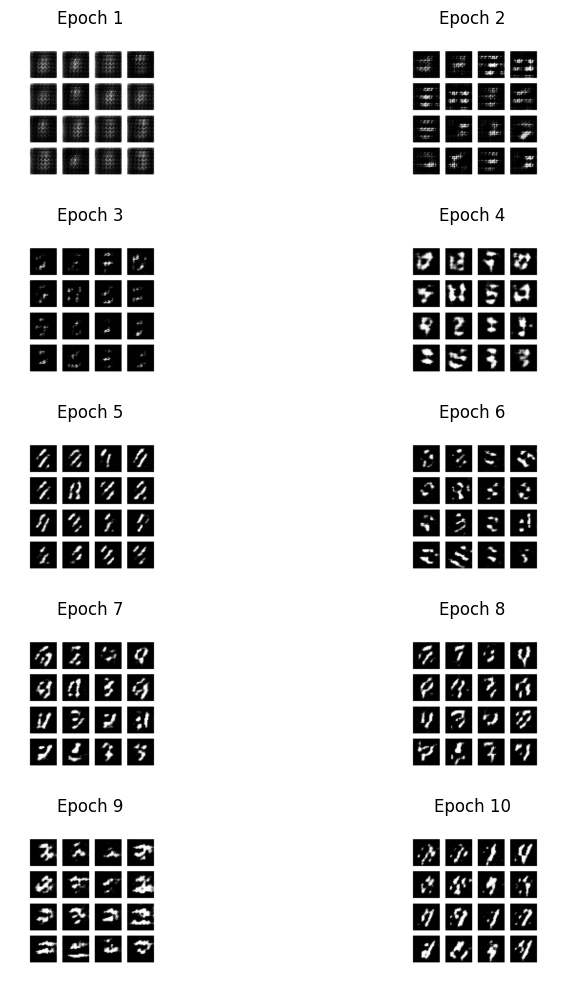

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Filepaths for the first 10 saved images
image_paths = [f"/content/image_at_epoch_{i:04d}.png" for i in range(1, 11)]

# Display the images in a grid
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    plt.subplot(5, 2, i + 1)  # 5 rows, 2 columns
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Epoch {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

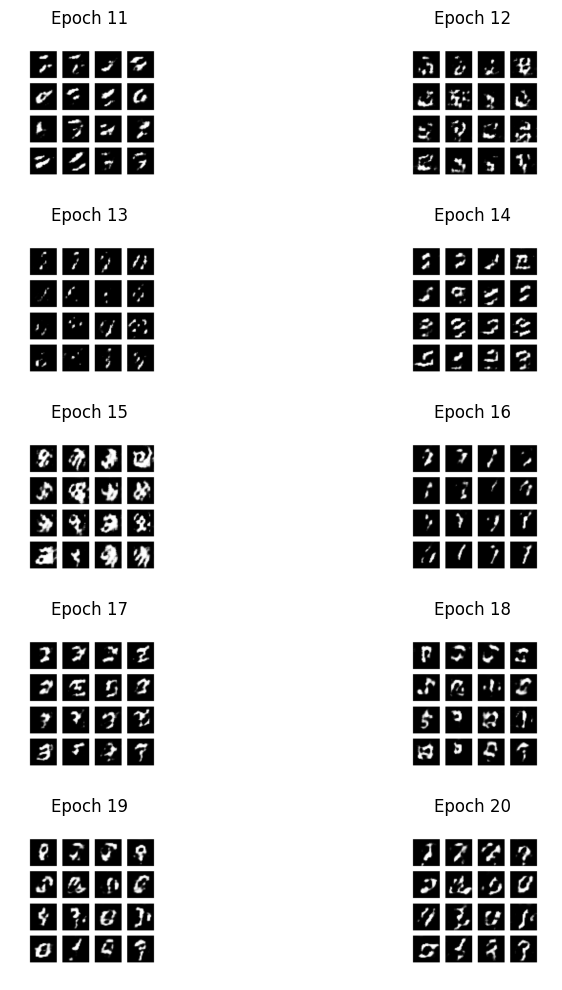

In [ ]:
# Epochs 11–20
image_paths = [f"/content/image_at_epoch_{i:04d}.png" for i in range(11, 21)]

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    plt.subplot(5, 2, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Epoch {i+11}")
    plt.axis('off')

plt.tight_layout()
plt.show()


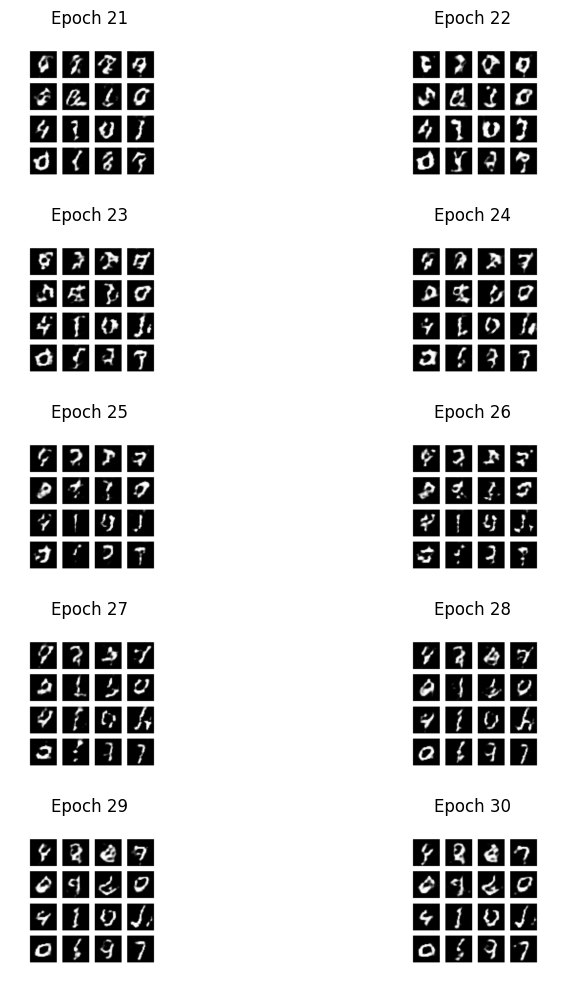

In [ ]:
# Epochs 21–30
image_paths = [f"/content/image_at_epoch_{i:04d}.png" for i in range(21, 31)]

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    plt.subplot(5, 2, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Epoch {i + 21}")
    plt.axis('off')

plt.tight_layout()
plt.show()

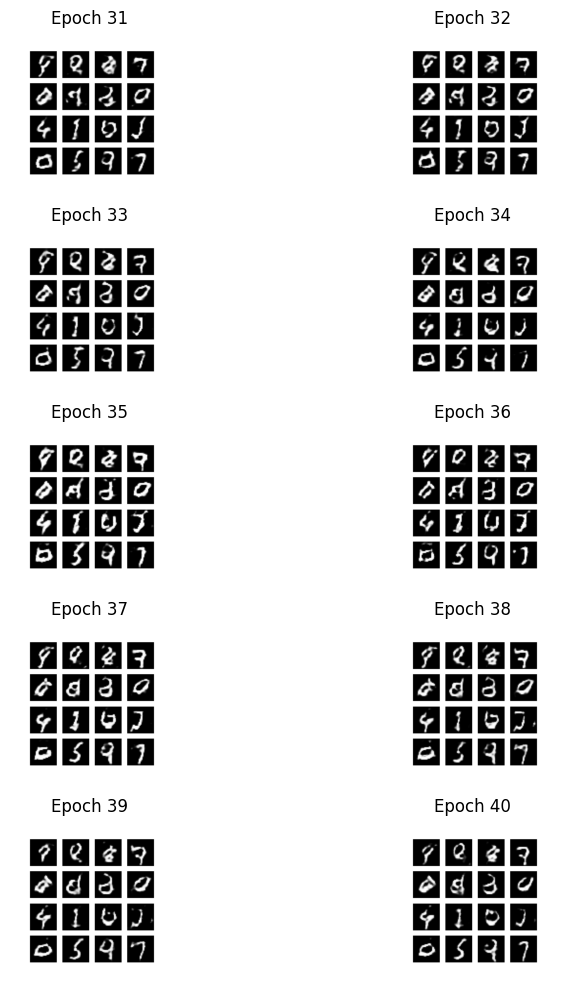

In [ ]:
# Epochs 31–40
image_paths = [f"/content/image_at_epoch_{i:04d}.png" for i in range(31, 41)]
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    plt.subplot(5, 2, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Epoch {i + 31}")
    plt.axis('off')

plt.tight_layout()
plt.show()


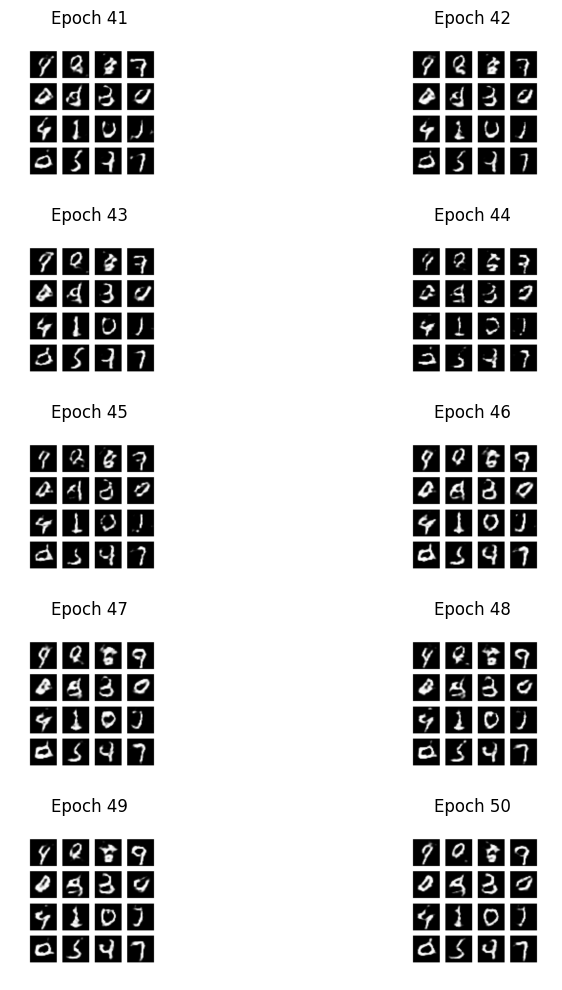

In [ ]:
# Epochs 41–50
image_paths = [f"/content/image_at_epoch_{i:04d}.png" for i in range(41, 51)]
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    plt.subplot(5, 2, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Epoch {i + 41}")
    plt.axis('off')

plt.tight_layout()
plt.show()


The images got notably sharper as the epochs progressed.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

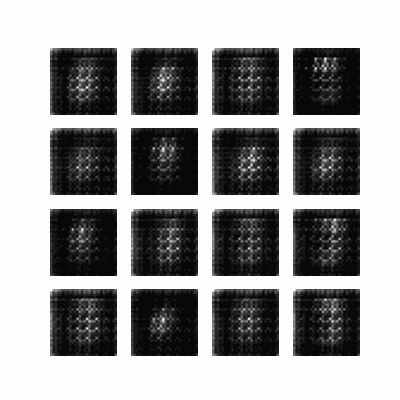

In [ ]:
import glob
import imageio.v2 as imageio  # Use v2 explicitly to avoid the warning
from IPython.display import Image, display

# Save the evolution of images as a GIF file
anim_file = 'GAN_digit.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/image_at_epoch_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)  # Read each image
        writer.append_data(image)  # Add to GIF
    # Append the last image to ensure the GIF finishes on the final frame
    image = imageio.imread(filename)
    writer.append_data(image)

# Display the GIF in the notebook
display(Image(anim_file))


In [ ]:
# what is your understanding from this GIF file?


The images are getting clearer. It is not unlike a flipbook where the figures move to a destination as each new page is revealed. As the Gif moves through the pictures/epochs the numbers look like they are becoming more clear.

**Part 2- Pokemon characters and GAN**

In [ ]:
#Install d2l package
!pip install d2l==1.0.0-alpha1.post0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ip

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
#a- Read the dataset and store it
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

# We store the directory in this variable
data_dir = d2l.download_extract('pokemon')
batch_size = 256
# Use preprocessing from Keras to read images from directory using given batch size and map them to 64x64 images
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))

Found 40597 files belonging to 721 classes.


In [ ]:
# Normalize the data to [-1, 1] using Gaussian normalization
# Mean = 0.5, Standard Deviation = 0.5
def transform_func(X):
    """
    Normalize the input images to the range [-1, 1] using Gaussian normalization.

    Args:
        X (Tensor): Input image batch.

    Returns:
        Tensor: Normalized image batch.
    """
    # Convert pixel values to range [0, 1]
    X = X / 255.0
    # Normalize to range [-1, 1] with mean=0.5 and std=0.5
    X = (X - 0.5) / 0.5
    return X

# Transform the dataset
data_iter = pokemon.map(
    lambda x, y: (transform_func(x), y),  # Normalize the image batch
    num_parallel_calls=tf.data.experimental.AUTOTUNE  # Optimize data loading
)

# Optimize the dataset pipeline: cache, shuffle, prefetch
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

# Print a batch to confirm the transformation
for batch in data_iter.take(1):
    images, labels = batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Sample normalized pixel values (min, max):",
          tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())


Image batch shape: (256, 64, 64, 3)
Label batch shape: (256,)
Sample normalized pixel values (min, max): -1.0 1.0


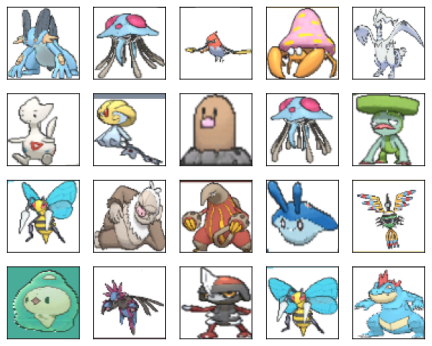

In [ ]:
#b- Visualize first 20 images
d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

## The Generator

The generator needs to map the noise variable to a RGB image with width and height to be $64\times 64$ .

In [ ]:
#c- Creating the generator
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [ ]:
# Explain your understanding of the G_block here.


The G_block is a custom layer for the generator in a GAN, designed to perform *upsampling*. It uses:

1. Conv2DTranspose: A transposed convolution to increase the spatial dimensions (height and width) of the input.
2. BatchNormalization: Stabilizes and accelerates training by normalizing the outputs of the convolution. (think uniformity)
3. ReLU Activation: Introduces non-linearity, enabling the generator to model complex patterns.

Together, these components form a modular building block to progressively generate higher-resolution images in the generator.

In [ ]:
x = tf.zeros((2, 16, 16, 3))  # Input based on the instruction
#Call the G_block package and use 20 as the number of layers (input of the class)
g_blk = G_block(20)
# Show the dimension of the output
g_blk(x).shape

TensorShape([2, 32, 32, 20])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.

In [ ]:
n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G*8, strides=1, padding="valid"),
    G_block(out_channels=n_G*4), # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G*2), # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G), # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", use_bias=False,
        activation="tanh")
])

In [ ]:
# Generate a 100 dimensional latent variable to verify the generator's output shape.
x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

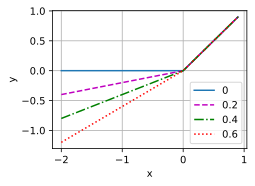

In [ ]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block

In [ ]:
# d- Block of Discriminator
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [ ]:
# Explain your understanding of D_block here.


The D_block is similar to G_block, whilst being perfectly opposite. It is a custom layer for the discriminator in a GAN, designed to *downsample* inputs while learning spatial features.

It includes:

1. Conv2D: A convolutional layer that reduces spatial dimensions (height and width) while capturing patterns in the input.
2. BatchNormalization: Normalizes the output of the convolution, improving stability during training.
3. LeakyReLU Activation: Adds non-linearity, allowing gradients to flow even for negative inputs, which helps prevent the "dying ReLU" problem.

Together, these components make D_block a modular unit for progressively reducing the spatial dimensions of the input while retaining important features for real vs. fake classification.

In [ ]:
x = tf.zeros((2, 16, 16, 3))
#Call the G_block package and use 20 as the number of layers (input of the class)
d_blk = D_block(20)
# Show the dimension of the output
d_blk(x).shape


TensorShape([2, 8, 8, 20])

The discriminator is a mirror of the generator.


In [ ]:
n_D = 64  # Base number of channels

# Define the discriminator network
net_D = tf.keras.Sequential([
    D_block(out_channels=n_D),              # Output: (32, 32, 64)
    D_block(out_channels=n_D * 2),          # Output: (16, 16, 128)
    D_block(out_channels=n_D * 4),          # Output: (8, 8, 256)
    D_block(out_channels=n_D * 8),          # Output: (4, 4, 512)
    tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias=False)  # Output: (1, 1, 1)
])

# Test the network with a dummy input
dummy_input = tf.random.normal([1, 64, 64, 3])  # Input: Batch size 1, 64x64 RGB image
output = net_D(dummy_input)

print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)


Input shape: (1, 64, 64, 3)
Output shape: (1, 1, 1, 1)


## Training




In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_hp = {"lr": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1,
                                 shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)],
                                    axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device._device_name)}')

In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device=d2l.try_gpu()):
    # Define binary cross-entropy loss
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    # Initialize weights of the networks
    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    # Correct the optimizer hyperparameters
    optimizer_hp = {"learning_rate": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    # Set up the animator
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # Tracks loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1, shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        fake_x = net_G(Z) / 2 + 0.5  # Normalize to [0, 1]
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)], axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)

        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device._device_name)}')


In [ ]:
# Explain your understanding from this model here?


The GAN training function is designed to help two neural networks, the **generator** and **discriminator**, compete and improve over time. The discriminator’s job is to distinguish between real and fake images, while the generator learns to produce fake images that are realistic enough to fool the discriminator. To achieve this, the function first initializes both networks with random weights and uses a binary cross-entropy loss to measure performance. The discriminator is rewarded for correctly classifying real and fake images, while the generator is rewarded when the discriminator incorrectly labels its fake images as real. Both networks are trained with the Adam optimizer, which adapts the learning rate for stable progress. Special parameters, such as momentum values (`beta_1` and `beta_2`), are tuned specifically for GAN training to prevent erratic updates.

The training process is organized into loops. For each epoch, the model processes the dataset in little batches. In each batch, the generator produces fake images from the random noise (remember above?), and the discriminator evaluates both real images from the dataset and the fake images. The discriminator is updated first, learning to better distinguish between real and fake, followed by an update to the generator to create more realistic images. At its essence it is a competition between to competing models. Over time, the two networks improve in thier individual tasks, resulting in a generator that produces increasingly realistic images.

loss_D 0.044, loss_G 5.740, 737.0 examples/sec on /GPU:0


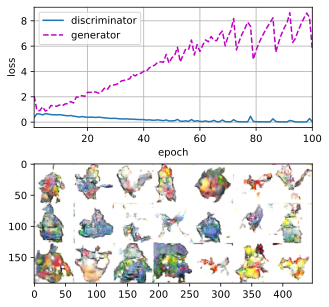

In [ ]:
latent_dim, lr, num_epochs = 100, 0.0005, 100

train(
    net_D=net_D,          # Discriminator network
    net_G=net_G,          # Generator network
    data_iter=data_iter,  # Training data iterator
    num_epochs=num_epochs,  # Number of epochs to train
    lr=lr,                # Learning rate
    latent_dim=latent_dim,  # Latent dimension
    device=d2l.try_gpu()  # Use GPU if available
)


In [ ]:
# what is your understanding from this learning curve?


The learning curve shows the progress of both the discriminator and generator over 100 epochs:

1. Discriminator Loss:

The discriminator loss remains very low (close to 0) throughout training.

This indicates the discriminator is highly confident in distinguishing real from fake images, potentially dominating the generator.

2. Generator Loss:

The generator loss steadily increases, showing that the generator struggles to fool the discriminator as training progresses.
This imbalance suggests the discriminator may be overpowering the generator, leading to difficulty for the generator to improve.

3. Generated Images:

While the generator starts producing vaguely Pokémon-like images, they remain blurry and lack fine detail even after 100 epochs.

This could indicate issues like:

Insufficient generator training or capacity.

Imbalanced GAN dynamics (discriminator learning too fast).